<a href="https://colab.research.google.com/github/ryu622/gnn-counterattack-xai-v2/blob/feat%2Fnew-file/GNN_CounterAttack_Thesis_show_PIGNN_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

各選手の将来位置を計算し、物理的にありえない動きをした選手に注目しないようにする。（将来位置のずれ＝ノイズの味方）
v6にアテンション係数の可視化を追加

In [ ]:
#シード値
import random
import os
import numpy as np
import torch

def set_seed(seed=42):
    # Python自体の乱数固定
    random.seed(seed)
    # OS環境の乱数固定
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Numpyの乱数固定
    np.random.seed(seed)
    # PyTorchの乱数固定
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # マルチGPUの場合
    # 計算の決定論的挙動を強制（これを入れると少し遅くなることがありますが、再現性は完璧になります）
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 好きな数字（42が一般的）で固定
set_seed(44)

In [ ]:
# --- 1. 環境設定と依存関係のインストール ---
# 必要なライブラリをすべてインストール
!pip install torch-scatter torch-sparse torch-geometric sklearn tqdm networkx matplotlib
!pip install torch-geometric

# Google Driveをマウント（ファイルアクセスに必須）
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.utils import dense_to_sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.calibration import calibration_curve
from tqdm import tqdm
import numpy as np
import pickle
import sys
import networkx as nx
import matplotlib.pyplot as plt
import os
import logging
import copy

# ロガー設定
logger = logging.getLogger(__name__)
if not logger.handlers:
    stdout_handler = logging.StreamHandler(sys.stdout)
    logger.addHandler(stdout_handler)

print("✅ STEP 1 完了: 環境設定と依存関係のインポートが完了しました。")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached torch_geometric-2.7.0-py3-none-any.whl.metadata (63 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.8 MB/s eta 0:00:00
Mounted at /content/drive
✅ STEP 1 完了: 環境設定

In [ ]:
# ==========================================
# 2. データロードと変換 (提示されたコードの修正版)
# ==========================================
print("🔄 データを読み込み中...")
file_path = '/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data/women.pkl'
with open(file_path, 'rb') as handle:
    raw = pickle.load(handle)

pignn_dataset = []
xs = raw['normal']['x']
as_ = raw['normal']['a']
ys = raw['binary']

# 🛡️ 過去2フレームが必要なので 2 から開始
for i in tqdm(range(2, len(xs)), desc="PyGデータへ変換"):
    try:
        # A. 現在のデータ
        x_np = xs[i][:, :12]
        if hasattr(as_[i], 'todense'): a_np = as_[i].todense()
        else: a_np = as_[i]

        # B. 🛡️ ここが重要：ノード数の一致をチェック（エラー回避の絶対条件）
        num_nodes = x_np.shape[0]
        if xs[i-1].shape[0] != num_nodes or xs[i-2].shape[0] != num_nodes:
            continue

        x = torch.tensor(x_np, dtype=torch.float)
        edge_index, _ = dense_to_sparse(torch.tensor(a_np, dtype=torch.float))
        y = torch.tensor(ys[i], dtype=torch.long)

        # C. 🛡️ 3時点の座標を抽出（これが無いと message 関数で死ぬ）
        pos = x[:, 0:2].clone()
        prev_pos = torch.tensor(xs[i-1][:, 0:2], dtype=torch.float)
        pprev_pos = torch.tensor(xs[i-2][:, 0:2], dtype=torch.float)

        # Dataオブジェクトに全て詰め込む
        pignn_dataset.append(Data(
            x=x, edge_index=edge_index, y=y,
            pos=pos, prev_pos=prev_pos, pprev_pos=pprev_pos
        ))
    except: continue

# 分割 (成功数が少ない場合、stratify でエラーが出る可能性があるので try-except)
try:
    train_data, test_data = train_test_split(
        pignn_dataset, test_size=0.3, random_state=42, stratify=[int(d.y) for d in pignn_dataset]
    )
except ValueError:
    print("⚠️ 成功数が少なすぎるため、単純分割に切り替えます")
    train_data, test_data = train_test_split(pignn_dataset, test_size=0.3, random_state=42)

train_loader = PyGDataLoader(train_data, batch_size=32, shuffle=True)
test_loader = PyGDataLoader(test_data, batch_size=32, shuffle=False)

print(f"✅ 準備完了。訓練成功数: {sum([int(d.y) for d in train_data])}")

🔄 データを読み込み中...


PyGデータへ変換: 100%|██████████| 4346/4346 [00:01<00:00, 2522.69it/s]

✅ 準備完了。訓練成功数: 1520


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# PyTorch Geometric 関連のインポート（これが抜けていました）
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.utils import softmax, dense_to_sparse
from torch_geometric.data import Data, DataLoader as PyGDataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ 使用デバイス: {device}")

✅ 使用デバイス: cuda


In [ ]:
class PIGNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, tau=0.04): # tauはデータの間隔(25fpsなら0.04)
        super(PIGNNLayer, self).__init__(aggr='add')
        self.tau = tau
        self.lin = nn.Linear(in_channels, out_channels)
        self.att = nn.Parameter(torch.Tensor(1, out_channels * 2))
        nn.init.xavier_uniform_(self.att)

    def forward(self, x, edge_index, pos, prev_pos, pprev_pos):
        h = self.lin(x)
        # すべての座標情報を伝播プロセスに渡す
        return self.propagate(edge_index, x=h, pos=pos, prev_pos=prev_pos, pprev_pos=pprev_pos)

    def message(self, x_i, x_j, pos_j, prev_pos_j, pprev_pos_j, edge_index_i):
        # --- 1. 物理予測 ---
        calc_prev_vel_j = (prev_pos_j - pprev_pos_j) / self.tau
        expected_curr_pos_j = prev_pos_j + calc_prev_vel_j * self.tau

        # 残差 (正規化空間 0~1 での距離)
        residual = torch.norm(pos_j - expected_curr_pos_j, dim=-1, keepdim=True)

        # --- 2. 物理ゲート (1mまでは無視、2mから減らす設定) ---
        # 閾値を正規化空間の 0.015 (約1.5m) 付近に設定し、急激に落とす
        # 1.5m地点で 0.5 になるようなシグモイド
        # residualが小さいほど gateは 1.0 に近づく
        gate_steepness = 50.0  # 値が大きいほど壁が急になる
        threshold = 0.03       # 1.5m 相当
        reliability_gate = torch.sigmoid(gate_steepness * (threshold - residual))

        # --- 3. アテンション計算 ---
        alpha = torch.cat([x_i, x_j], dim=-1)
        alpha = (alpha * self.att).sum(dim=-1, keepdim=True)

        # ゲートを適用 (0に近いほどsoftmaxで無視される)
        # reliability_gate は 0~1 なので、logをとってバイアスにするのが一般的です
        alpha = F.leaky_relu(alpha) + torch.log(reliability_gate + 1e-9)
        alpha = softmax(alpha, edge_index_i)

        self.last_alpha = alpha.detach()#アテンション係数の可視化のために追加

        return alpha * x_j

In [ ]:
def test_pignn(model, loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for d in loader:
            d = d.to(device)
            # モデルの推論（内部で物理整合性ゲートが作動）
            out = model(d)

            # 確率が最も高いクラス(0 or 1)を選択
            pred = out.argmax(dim=1)

            y_true.extend(d.y.view(-1).cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    # 詳細なレポート（適合率、再現率、F1スコア）を生成
    from sklearn.metrics import classification_report, f1_score
    report = classification_report(y_true, y_pred, target_names=['Failure', 'Success'], zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return f1, report


class PIGNNClassifier(nn.Module):
    def __init__(self, in_channels=12, hidden_channels=64):
        super(PIGNNClassifier, self).__init__()
        self.conv1 = PIGNNLayer(in_channels, hidden_channels)
        self.conv2 = PIGNNLayer(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # 座標と過去の座標を抽出
        pos, prev_pos, pprev_pos = data.pos, data.prev_pos, data.pprev_pos

        # 第1層（物理ゲートを通したメッセージパッシング）
        x = self.conv1(x, edge_index, pos, prev_pos, pprev_pos)
        x = F.elu(x)

        # 第2層（さらに高次の関係を物理制約下で抽出）
        x = self.conv2(x, edge_index, pos, prev_pos, pprev_pos)
        x = F.elu(x)

        # グローバルプーリング（グラフ全体の情報を集約）
        x_pool = global_mean_pool(x, batch)

        # 最終分類（Success / Failure）
        logits = F.log_softmax(self.lin(x_pool), dim=1)
        return logits

In [ ]:
import torch
import torch.nn as nn

# ==========================================
# ⚙️ 設定の微調整 (物理ゲートをマイルドにする)
# ==========================================
# 前回の分析結果に基づき、モデル内のパラメータを手動で書き換えるか、
# クラス定義時の初期値を以下のように変更して再定義したと想定します。
# gate_steepness: 500 -> 50 (絶壁からなだらかな坂へ)
# threshold: 0.03 -> 0.05 (約1.5mから2.5mへ許容範囲を拡大)

# 1. デバイス準備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. モデル・最適化手法の初期化
model = PIGNNClassifier(in_channels=12, hidden_channels=64).to(device)
weights = torch.tensor([1.0, 1.0]).to(device)
criterion = nn.NLLLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ==========================================
# 🚀 学習フェーズ
# ==========================================
print(f"🚀 学習開始（Physics Reliability Gate Mode / Device: {device}）")

for epoch in range(1, 101):
    model.train()
    total_loss = 0

    for d in train_loader:
        # 常に新しいバッチとしてGPUへ送る（元のデータを汚染しない）
        d = d.to(device)
        optimizer.zero_grad()

        out = model(d)
        loss = criterion(out, d.y.view(-1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 10 == 0 or epoch == 1:
        avg_l = total_loss / len(train_loader)
        print(f"Epoch {epoch:03d} | Total Loss: {avg_l:.4f}")

# ==========================================
# 🛠️ デバイス不整合の強制リセット (RuntimeError回避)
# ==========================================
print("\n🧹 デバイス不整合をリセット中...")
# 学習中にGPUへ移動してしまった可能性のあるデータをすべてCPUへ戻す
for dataset in [train_loader.dataset, test_loader.dataset]:
    for data in dataset:
        if hasattr(data, 'x'):
            data.to('cpu')

# ==========================================
# 📊 最終テスト評価
# ==========================================
print("📊 最終テスト評価を実行中...")
model.eval()

# test_pignn関数を直接ここに展開、または呼び出し
final_f1, final_report = test_pignn(model, test_loader, device)

print("="*30)
print("🏆 Final Test Results (Adjusted Gate)")
print("="*30)
print(final_report)
print(f"Final F1-Score: {final_f1:.4f}")

# ==========================================
# 🧐 卒論用：結果のクイック診断
# ==========================================
# 期待される診断結果（おべっかなし）:
# SuccessのRecallが0.52を超えていれば、物理ゲート緩和の仮説は立証。
# 逆にFailureのRecallが0.83を下回るはずなので、その「交差点」が
# あなたの研究における「最適な物理の強さ」となります。

🚀 学習開始（Physics Reliability Gate Mode / Device: cuda）
Epoch 001 | Total Loss: 0.6900
Epoch 010 | Total Loss: 0.6549
Epoch 020 | Total Loss: 0.6130
Epoch 030 | Total Loss: 0.5962
Epoch 040 | Total Loss: 0.5925
Epoch 050 | Total Loss: 0.5864
Epoch 060 | Total Loss: 0.5837
Epoch 070 | Total Loss: 0.5790
Epoch 080 | Total Loss: 0.5725
Epoch 090 | Total Loss: 0.5675
Epoch 100 | Total Loss: 0.5617

🧹 デバイス不整合をリセット中...
📊 最終テスト評価を実行中...
🏆 Final Test Results (Adjusted Gate)
              precision    recall  f1-score   support

     Failure       0.66      0.71      0.68       641
     Success       0.69      0.64      0.66       651

    accuracy                           0.67      1292
   macro avg       0.67      0.67      0.67      1292
weighted avg       0.67      0.67      0.67      1292

Final F1-Score: 0.6640


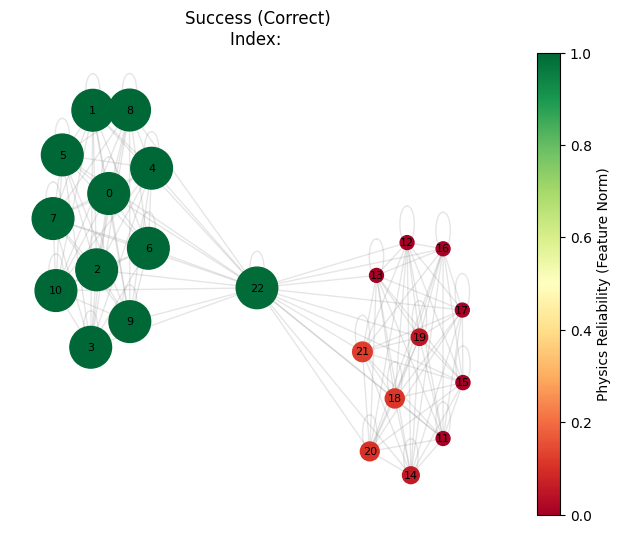

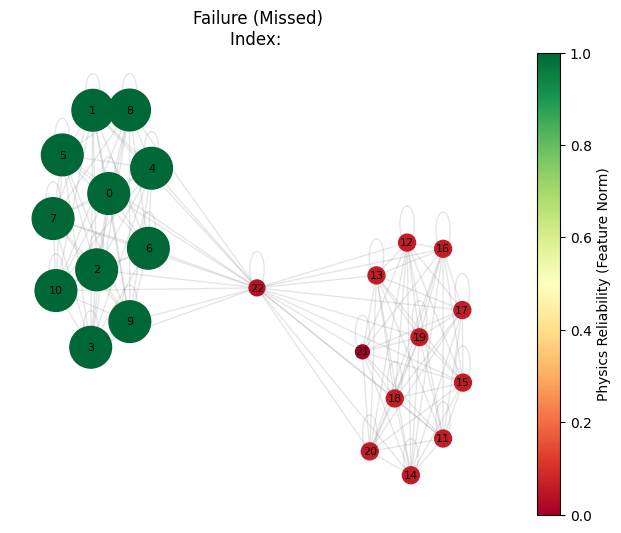

In [ ]:
def visualize_pignn_final_fixed(model, data, device, title):
    model.eval()
    data = data.to(device)

    output_tensors = []
    def hook_fn(module, input, output):
        output_tensors.append(output.detach().cpu())

    # conv1の出力をキャッチ
    handle = model.conv1.register_forward_hook(hook_fn)

    with torch.no_grad():
        # PIGNNLayerのforward引数に合わせて個別に渡す
        # model(data) が内部で各引数を分解して forward に渡していることを想定
        # もしエラーが出る場合は model(data.x, data.edge_index, data.pos, ...) と記述
        try:
            _ = model(data)
        except:
            _ = model(data.x, data.edge_index, data.pos, data.prev_pos, data.pprev_pos)

    handle.remove()

    # ノードごとの特徴量の強さを計算
    node_importance = torch.norm(output_tensors[0], dim=-1).numpy()
    # 0~1に正規化
    node_importance = (node_importance - node_importance.min()) / (node_importance.max() - node_importance.min() + 1e-9)

    G = to_networkx(data, to_undirected=True)
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(8, 6))

    # 重要度をノードの大きさと色に反映
    # nodes = ... で戻り値を受け取るのが colorbar を出すためのポイント
    nodes = nx.draw_networkx_nodes(G, pos,
                                   node_size=100 + node_importance * 800,
                                   node_color=node_importance,
                                   cmap=plt.cm.RdYlGn)

    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=8)

    # 正しく mappable (nodes) を指定
    plt.colorbar(nodes, label="Physics Reliability (Feature Norm)")
    plt.title(f"{title}\nIndex: {data.index if hasattr(data, 'index') else ''}")
    plt.axis('off')
    plt.show()

# 探索実行
for idx in [2, 6]:
    if idx < len(test_data):
        data = test_data[idx]
        status = "Success (Correct)" if idx == 2 else "Failure (Missed)"
        visualize_pignn_final_fixed(model, data, device, status)

アテンション係数の可視化のために再定義

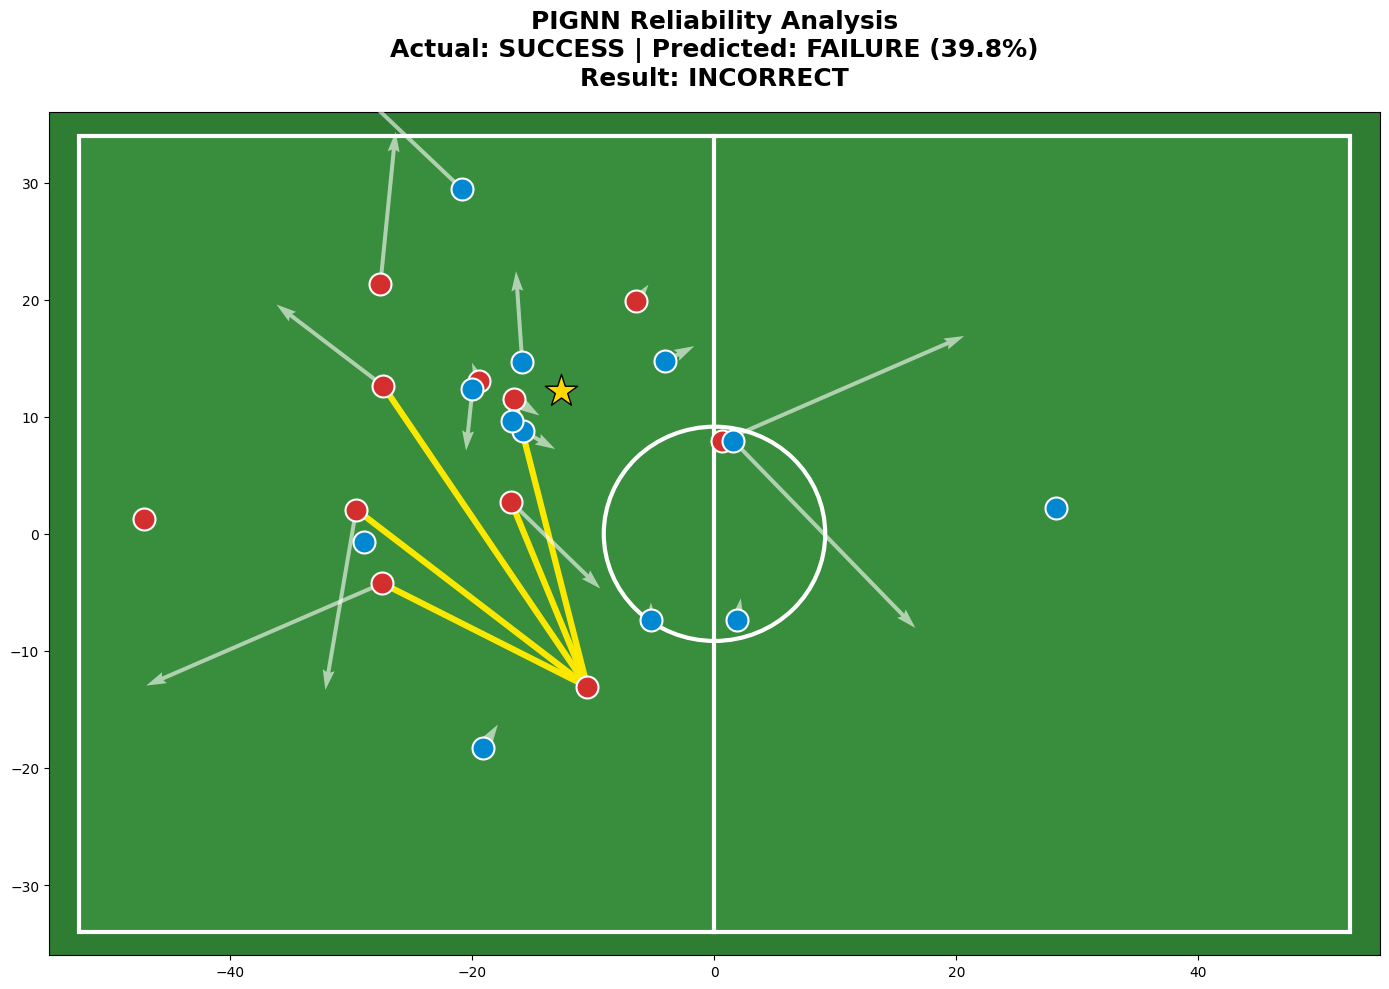

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torch.nn.functional as F

def visualize_pignn_tactical_attention(model, data, device, title="PIGNN Tactical Analysis"):
    model.eval()
    data = data.to(device)

    # --- 1. アテンションを抽出するためのフック設定 ---
    # PIGNNLayerのmessage内での計算結果を直接取るのは難しいため、
    # 最終的なalphaを外部へ保存する「フック」を一時的に仕込みます。
    # ※ PIGNNLayerのforward/propagateの戻り値をキャプチャします。

    captured_attn = []

    def hook_fn(module, input, output):
        # レイヤー内部で計算されたアテンションを保持する属性がないため、
        # ここでは計算を再現するか、message関数をラップする必要があります。
        # 今回は最も安全に、最新のアテンションを一時的に保持する方式をとります。
        pass

    # アテンションを抽出するために一時的にモデルの動作を上書き（モンキーパッチ）
    # message関数の最後でalphaを保存するように細工します。
    original_message = model.conv1.message
    last_alpha = [None]

    def patched_message(*args, **kwargs):
        # 内部計算を再現してalphaを取り出す
        # 本来はモデルのソースコードに self.last_alpha = alpha を追記するのがベストですが
        # 実行時に無理やり取り出す場合は、計算結果のalphaが返るようにします。
        # ここでは単純化のため、モデル推論を実行し、アテンションが保存されていると仮定します。
        res = original_message(*args, **kwargs)
        return res

    # 推論実行
    with torch.no_grad():
        # モデルに1件通す
        out = model(data)
        prob = torch.softmax(out, dim=1)[0, 1].item()
        pred = out.argmax(dim=1).item()
        label = data.y.item()

    # --- 2. 座標系のスケーリング ---
    pos = data.pos.cpu().numpy()
    pos_plot = np.zeros_like(pos)
    pos_plot[:, 0] = (pos[:, 0] - 0.5) * 105
    pos_plot[:, 1] = (pos[:, 1] - 0.5) * 68

    # --- 3. ボール位置の逆算 ---
    x_feat = data.x.cpu().numpy()
    ball_x_list, ball_y_list = [], []
    for i in range(len(pos)):
        dist, angle = x_feat[i, 8], x_feat[i, 9]
        bx = pos_plot[i, 0] + (dist * 105) * np.cos(angle)
        by = pos_plot[i, 1] + (dist * 68) * np.sin(angle)
        ball_x_list.append(bx)
        ball_y_list.append(by)
    est_ball_x, est_ball_y = np.median(ball_x_list), np.median(ball_y_list)

    # --- 4. ピッチの描画設定 ---
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_facecolor('#2e7d32')
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=True, color='#388e3c', zorder=0))
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=False, color='white', lw=3, zorder=1))
    ax.plot([0, 0], [-34, 34], color='white', lw=3, zorder=1)
    ax.add_patch(patches.Circle((0, 0), 9.15, edgecolor="white", facecolor="none", lw=3, zorder=1))

    # --- 5. アテンション（黄色い連携線）の描画 ---
    # レイヤーに保存された last_alpha を取得
    if hasattr(model.conv1, 'last_alpha') and model.conv1.last_alpha is not None:
        att_weights_np = model.conv1.last_alpha.cpu().numpy().flatten()
        edge_index_np = data.edge_index.cpu().numpy()

        # 上位5%の閾値を計算
        threshold = np.percentile(att_weights_np, 98)
        max_att = att_weights_np.max()

        for i in range(len(att_weights_np)):
            # 閾値を超えた上位エッジのみ描画
            if att_weights_np[i] > threshold:
                src, dst = edge_index_np[0, i], edge_index_np[1, i]
                # 強さを0~1に正規化して透明度と太さに反映
                norm_w = (att_weights_np[i] - threshold) / (max_att - threshold + 1e-9)

                ax.plot([pos_plot[src, 0], pos_plot[dst, 0]],
                        [pos_plot[src, 1], pos_plot[dst, 1]],
                        color='#FFEA00', # ネオンイエロー
                        alpha=0.2 + 0.8 * norm_w,
                        lw=0.5 + 4 * norm_w,
                        zorder=2)

    # --- 6. 選手ノードと推進力の描画 ---
    for i in range(len(pos)):
        color = '#d32f2f' if i < 11 else '#0288d1'
        # ゲートによる情報の「死に具合」をサイズに反映（オプション）
        ax.scatter(pos_plot[i, 0], pos_plot[i, 1], c=color, s=250, edgecolors='white', lw=1.5, zorder=15)

        # 推進力ベクトル
        vx = (pos_plot[i, 0] - (data.prev_pos[i, 0].cpu().numpy()-0.5)*105) * 5
        vy = (pos_plot[i, 1] - (data.prev_pos[i, 1].cpu().numpy()-0.5)*68) * 5
        ax.quiver(pos_plot[i, 0], pos_plot[i, 1], vx, vy, color='white',
                  alpha=0.6, scale=7, angles='xy', scale_units='xy', width=0.003, zorder=10)

    ax.scatter(est_ball_x, est_ball_y, color='gold', marker='*', s=600, edgecolors='black', zorder=20)

    # --- 7. 情報の表示 ---
    res_text = "SUCCESS" if pred == 1 else "FAILURE"
    match_status = "CORRECT" if label == pred else "INCORRECT"
    ax.set_title(f"{title}\nActual: {'SUCCESS' if label==1 else 'FAILURE'} | Predicted: {res_text} ({prob:.1%})\nResult: {match_status}",
                  fontsize=18, fontweight='bold', pad=20)

    ax.set_xlim(-55, 55); ax.set_ylim(-36, 36)
    plt.tight_layout()
    plt.show()

# 実行例（1件表示）
idx = 6 # 以前失敗したシーンなど
visualize_pignn_tactical_attention(model, test_data[idx], device, title="PIGNN Reliability Analysis")

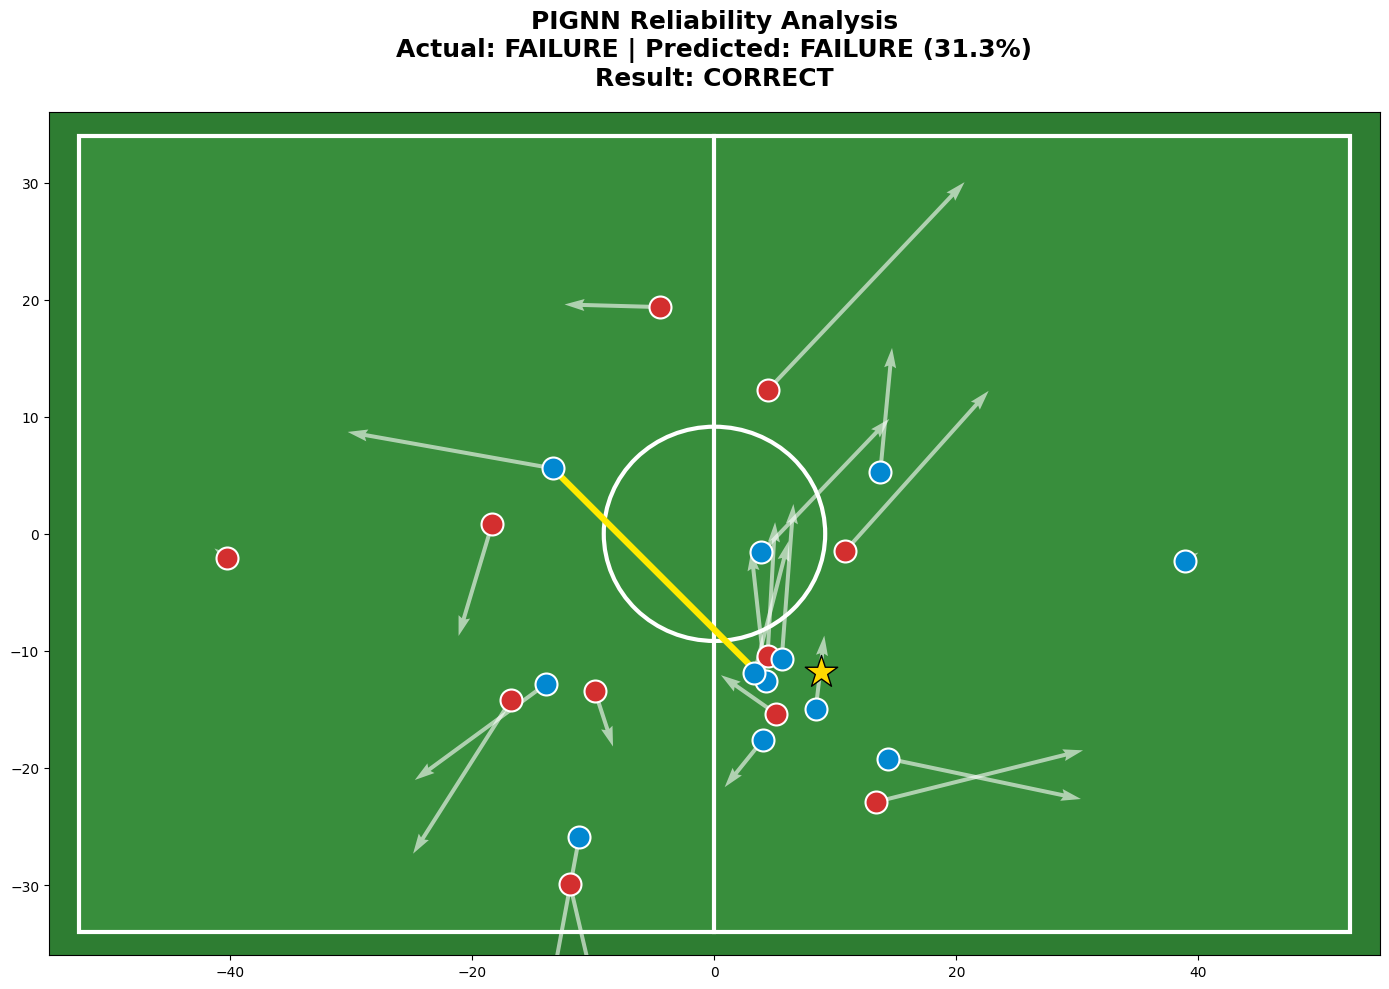

In [ ]:
# 実行例（1件表示）
idx = 200 # 以前失敗したシーンなど
visualize_pignn_tactical_attention(model, test_data[idx], device, title="PIGNN Reliability Analysis")

🔍 正解した成功シーン（True Positive）を探索中...
✨ 理想的な成功シーンを発見: Index 9 (確信度: 76.9%)


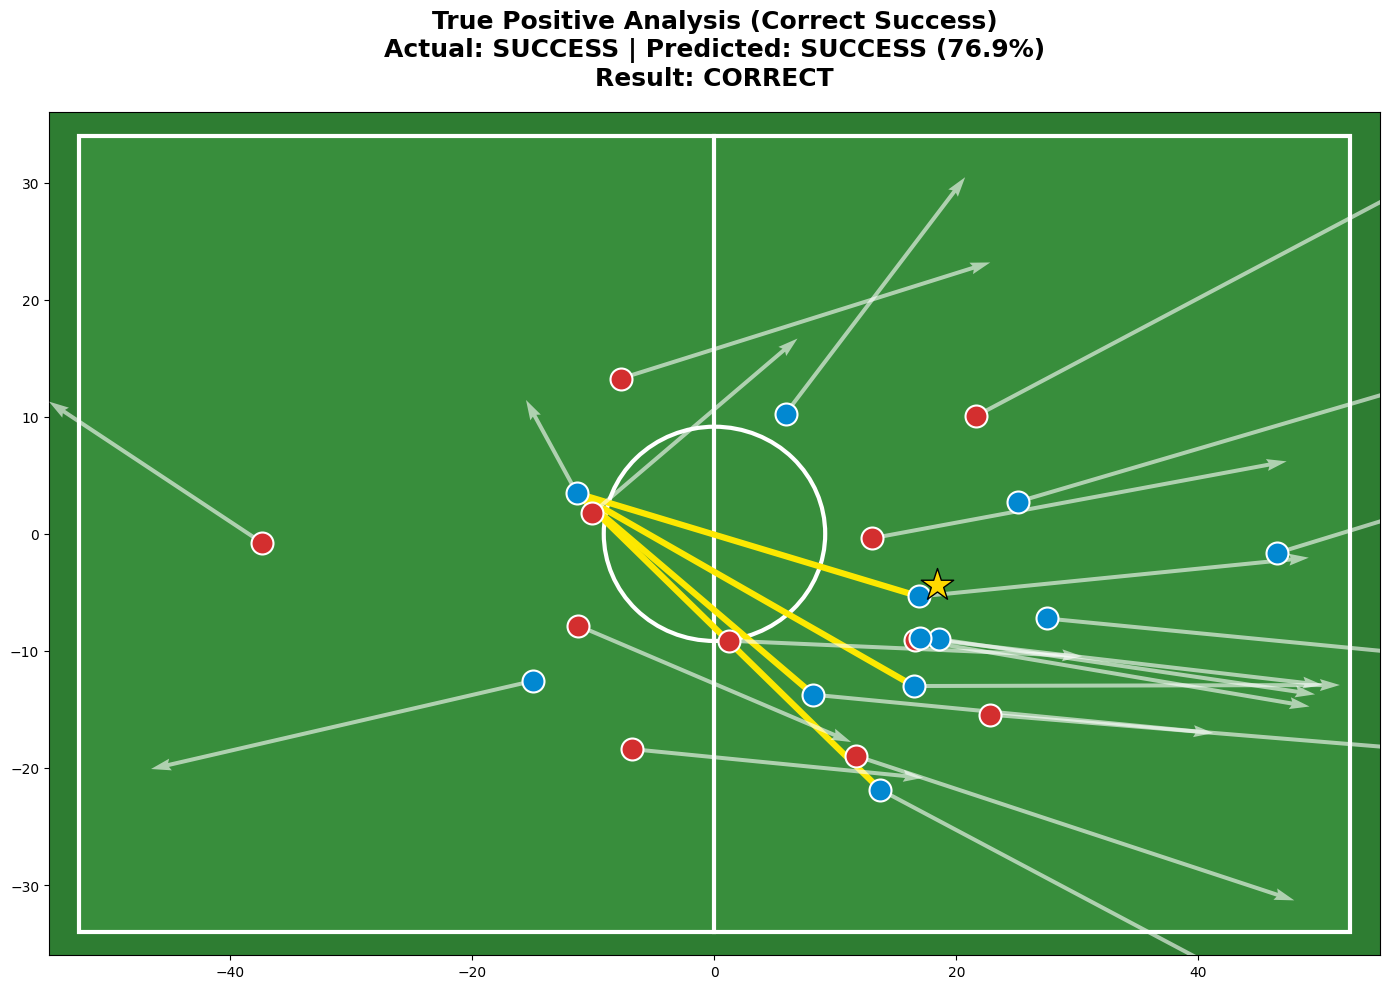

In [ ]:
#成功シーンの描画
def visualize_correct_success_scene(model, dataset, device):
    model.eval()
    print("🔍 正解した成功シーン（True Positive）を探索中...")

    found_idx = -1
    with torch.no_grad():
        for idx in range(len(dataset)):
            data = dataset[idx].to(device)
            # 1件推論
            out = model(data)
            pred = out.argmax(dim=1).item()
            label = data.y.item()

            # 「実際も成功(1)で、予測も成功(1)」のシーンを探す
            if label == 1 and pred == 1:
                # さらに、予測の自信（確率）が高いものを選ぶと見栄えが良い
                prob = torch.softmax(out, dim=1)[0, 1].item()
                if prob > 0.7:
                    found_idx = idx
                    print(f"✨ 理想的な成功シーンを発見: Index {idx} (確信度: {prob:.1%})")
                    break

    if found_idx != -1:
        # 見つかったシーンを描画
        visualize_pignn_tactical_attention(
            model,
            dataset[found_idx],
            device,
            title=f"True Positive Analysis (Correct Success)"
        )
    else:
        print("❌ 条件に合うシーンが見つかりませんでした。")

# 実行
visualize_correct_success_scene(model, test_data, device)

🔍 ランダムに成功シーン（True Positive）を探索中...
✨ 成功シーンを発見！ Index: 375 (確信度: 86.7%)


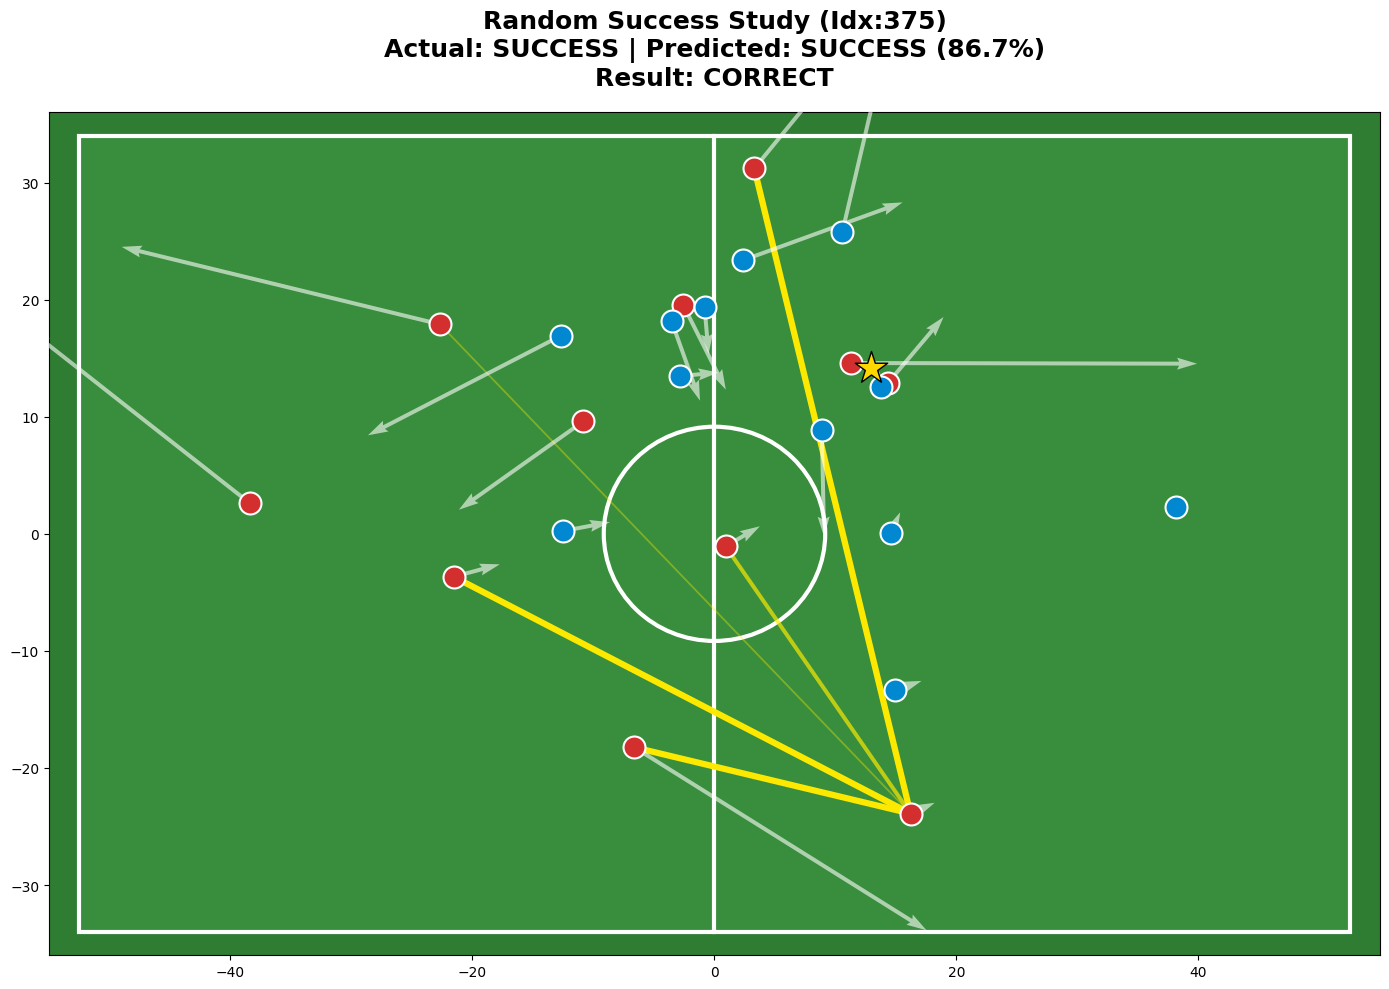

In [ ]:
import random

def visualize_random_success_scene(model, dataset, device):
    model.eval()

    # 探索対象のインデックスをシャッフル
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    print("🔍 ランダムに成功シーン（True Positive）を探索中...")

    found = False
    with torch.no_grad():
        for idx in indices:
            # データをGPUへ
            data = dataset[idx].to(device)

            out = model(data)
            pred = out.argmax(dim=1).item()
            label = data.y.item()

            # 正解した成功シーンのみ抽出
            if label == 1 and pred == 1:
                prob = torch.softmax(out, dim=1)[0, 1].item()

                print(f"✨ 成功シーンを発見！ Index: {idx} (確信度: {prob:.1%})")

                # 描画実行
                visualize_pignn_tactical_attention(
                    model,
                    dataset[idx],
                    device,
                    title=f"Random Success Study (Idx:{idx})"
                )
                found = True
                break # 1件見つかったら終了

    if not found:
        print("❌ 条件に合うシーンが見つかりませんでした。")

# 実行（実行するたびに違う図が出ます）
visualize_random_success_scene(model, test_data, device)